# Going Deeper 4. Augmentation 심화기법 적용

이번에는 최신 기법(CutMix, Mixup)을 적용해 모델을 훈련시켜보겠다. 데이터셋에 두 가지 방법 중 하나를 적용하고, 모델을 학습시키고 결과를 수치화하고 비교 해보자.


## 1. 데이터 불러오기

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

데이터셋은 stanford_dogs 데이터를 사용한다.

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

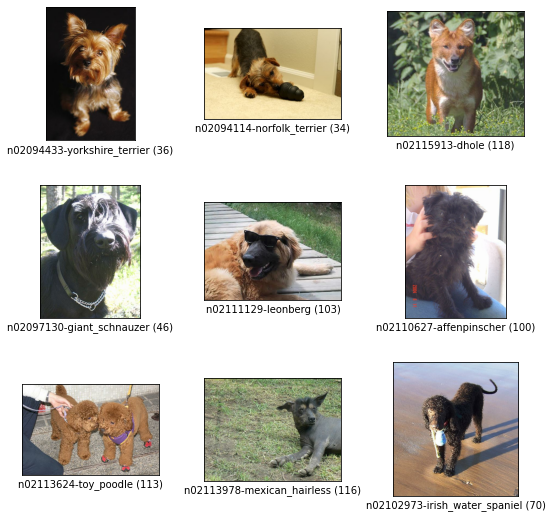

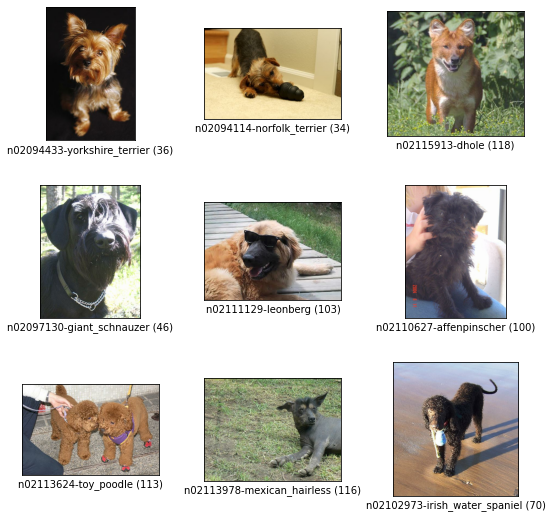

In [4]:
tfds.show_examples(ds_train, ds_info)

## 2. Augmentation 적용

In [5]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

이 함수는 입력받은 이미지를 0~1 사이의 float32로 normalize하고, (224, 224) 사이즈로 resize한다.

이 함수는 훈련용과 테스트용으로 사용될 모든 이미지에 적용될 것이다.

In [6]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

`augment` 함수는 `random_flip_left_right()` 과 `random_brightness()` 를 활용한다.

In [7]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

### CutMix Augmentation 기법

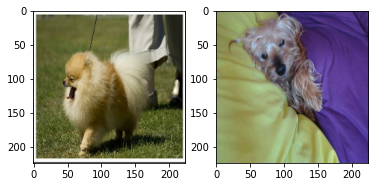

In [8]:
import matplotlib.pyplot as plt

ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

첫 번째 이미지 a를 바탕 이미지로 하고 거기에 삽입할 두 번째 이미지 b가 있을 때, a에 삽입될 영역의 바운딩 박스의 위치를 결정하는 `get_clip_box()` 함수를 구현한다.

In [9]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

바탕이미지 `image_a` 에서 바운딩 박스 바깥쪽 영역을, 다른 이미지 `image_b` 에서 바운딩 박스 안쪽 영역을 가져와서 합치는 `mix_2_images()`함수를 구현한다.

In [10]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

섞인 이미지의 면적에 비례해서 라벨을 섞는 `mix_2_labels()`함수를 구현한다.

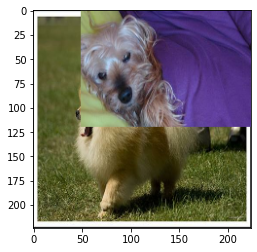

In [11]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

위에서 구현한 두 함수 `mix_2_images()` 와 `mix_2_label()`을 활용하여 배치 단위의 `cutmix()` 함수를 구현한다.

In [12]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### Mixup Augmentation 기법

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.88078964 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

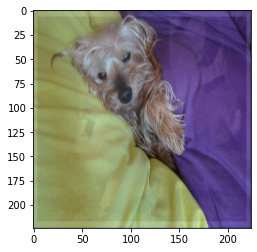

In [13]:
num_classes = ds_info.features["label"].num_classes

# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    a = tf.random.uniform([],0,1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-a)*image_a + a*image_b
    mixed_label = (1-a)*label_a + a*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
print(mixed_label)

In [14]:
def mixup(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [15]:
def onehot(image, label) :
    label = tf.one_hot(label, num_classes)
    return image, label

Augmentation을 통해 원본 데이터셋에 다양한 형태의 가공한 형태의 새로운 데이터셋을 얻게 되는 모든 과정을 구현한 메인 함수를 `apply_normalize_on_dataset()` 로 정의한다.  

이때, CutMix 기법을 적용하기 위해  `batch()` 함수 뒤에 CutMix 가 오도록 한다. CutMix는 배치 안에 있는 이미지끼리만 섞는 과정이기 때문에, 미리 배치 단위로 데이터셋을 정렬 후 CutMix가 적용되어야 한다.

In [16]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [17]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)


## 3. 모델 생성

텐서플로우 케라스의 ResNet50 중 imagenet으로 훈련된 모델을 불러온다.  

비교실험을 위해 
- Augmentation 이 적용되지않은 데이터셋으로 학습시킬 ResNet
- Augmentation 이 적용된 데이터셋으로 학습시킬 ResNet
- Cutmix 가 포함된 Augmenatiotion 이 적용된 데이터 셋으로 학습시킬 ResNet   
- Mixup 이 포함된 Augmenatiotion 이 적용된 데이터 셋으로 학습시킬 ResNet

으로 나누어 각각 모델을 불러온다.

In [18]:
# imagenet 데이터에 훈련된 ResNet50 모델 불러오기
resnet50_no_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,   # 마지막 fully connected layer 미포함
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')  # 데이터에 맞는 FC layer 붙여서 활용
])

In [19]:
resnet50_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [20]:
resnet50_cutmix = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [21]:
resnet50_mixup = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

## 4. 모델 훈련

`cutmix()`을 구현하면서 label의 mix 때문에 더이상 label이 스칼라값을 가지지 못하고 One-Hot 벡터 형태로 변환되었기 때문에 `sparse_categorical_crossentropy()` 대신 `categorical_crossentropy()`를 사용한다.

In [22]:
EPOCH = 20 

resnet50_no_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

resnet50_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

resnet50_cutmix.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

resnet50_mixup.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [23]:
history_resnet50_no_aug = resnet50_no_aug.fit(
    ds_train_no_aug, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 348s 427ms/step - loss: 3.2048 - accuracy: 0.2750 - val_loss: 3.1290 - val_accuracy: 0.2415
Epoch 2/20
750/750 [==============================] - 321s 428ms/step - loss: 0.9380 - accuracy: 0.7392 - val_loss: 1.1871 - val_accuracy: 0.6559
Epoch 3/20
750/750 [==============================] - 321s 428ms/step - loss: 0.3601 - accuracy: 0.9090 - val_loss: 0.9700 - val_accuracy: 0.7196
Epoch 4/20
750/750 [==============================] - 321s 428ms/step - loss: 0.1074 - accuracy: 0.9826 - val_loss: 0.9473 - val_accuracy: 0.7294
Epoch 5/20
750/750 [==============================] - 320s 427ms/step - loss: 0.0348 - accuracy: 0.9965 - val_loss: 0.9097 - val_accuracy: 0.7462
Epoch 6/20
750/750 [==============================] - 321s 428ms/step - loss: 0.0167 - accuracy: 0.9997 - val_loss: 0.9192 - val_accuracy: 0.7444
Epoch 7/20
750/750 [==============================] - 321s 428ms/step - loss: 0.0136 - accuracy: 0.9998 - val_loss: 0.9509 -

In [24]:
history_resnet50_aug = resnet50_aug.fit(
    ds_train_aug, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 328s 429ms/step - loss: 3.2473 - accuracy: 0.2670 - val_loss: 2.9401 - val_accuracy: 0.2657
Epoch 2/20
750/750 [==============================] - 321s 428ms/step - loss: 1.1015 - accuracy: 0.6819 - val_loss: 1.1756 - val_accuracy: 0.6593
Epoch 3/20
750/750 [==============================] - 321s 428ms/step - loss: 0.6232 - accuracy: 0.8226 - val_loss: 1.0578 - val_accuracy: 0.6899
Epoch 4/20
750/750 [==============================] - 320s 427ms/step - loss: 0.3361 - accuracy: 0.9143 - val_loss: 1.1478 - val_accuracy: 0.6777
Epoch 5/20
750/750 [==============================] - 321s 428ms/step - loss: 0.1717 - accuracy: 0.9631 - val_loss: 0.9928 - val_accuracy: 0.7133
Epoch 6/20
750/750 [==============================] - 320s 427ms/step - loss: 0.0940 - accuracy: 0.9853 - val_loss: 0.9827 - val_accuracy: 0.7238
Epoch 7/20
750/750 [==============================] - 321s 428ms/step - loss: 0.0633 - accuracy: 0.9896 - val_loss: 0.9743 -

In [25]:
history_resnet50_cutmix = resnet50_cutmix.fit(
    ds_train_cutmix, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 329s 431ms/step - loss: 4.3343 - accuracy: 0.1157 - val_loss: 3.9644 - val_accuracy: 0.1489
Epoch 2/20
750/750 [==============================] - 322s 429ms/step - loss: 3.0467 - accuracy: 0.3927 - val_loss: 1.5093 - val_accuracy: 0.5852
Epoch 3/20
750/750 [==============================] - 322s 429ms/step - loss: 2.6898 - accuracy: 0.5102 - val_loss: 1.2371 - val_accuracy: 0.6522
Epoch 4/20
750/750 [==============================] - 322s 430ms/step - loss: 2.4472 - accuracy: 0.5943 - val_loss: 1.2824 - val_accuracy: 0.6509
Epoch 5/20
750/750 [==============================] - 322s 429ms/step - loss: 2.3005 - accuracy: 0.6375 - val_loss: 1.2736 - val_accuracy: 0.6579
Epoch 6/20
750/750 [==============================] - 322s 429ms/step - loss: 2.1745 - accuracy: 0.6815 - val_loss: 1.1882 - val_accuracy: 0.6743
Epoch 7/20
750/750 [==============================] - 322s 429ms/step - loss: 2.0781 - accuracy: 0.7138 - val_loss: 1.1679 -

In [26]:
history_resnet50_mixup = resnet50_mixup.fit(
    ds_train_mixup, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 329s 431ms/step - loss: 4.2447 - accuracy: 0.1401 - val_loss: 4.0519 - val_accuracy: 0.1151
Epoch 2/20
750/750 [==============================] - 322s 429ms/step - loss: 2.9276 - accuracy: 0.4607 - val_loss: 1.6239 - val_accuracy: 0.5527
Epoch 3/20
750/750 [==============================] - 322s 430ms/step - loss: 2.6302 - accuracy: 0.5614 - val_loss: 1.3626 - val_accuracy: 0.6157
Epoch 4/20
750/750 [==============================] - 321s 429ms/step - loss: 2.3793 - accuracy: 0.6515 - val_loss: 1.6471 - val_accuracy: 0.5588
Epoch 5/20
750/750 [==============================] - 322s 430ms/step - loss: 2.2682 - accuracy: 0.7056 - val_loss: 1.1934 - val_accuracy: 0.6684
Epoch 6/20
750/750 [==============================] - 322s 429ms/step - loss: 2.1769 - accuracy: 0.7449 - val_loss: 1.3637 - val_accuracy: 0.6353
Epoch 7/20
750/750 [==============================] - 322s 429ms/step - loss: 2.0719 - accuracy: 0.7725 - val_loss: 1.2622 -

## 5. 훈련 과정 시각화

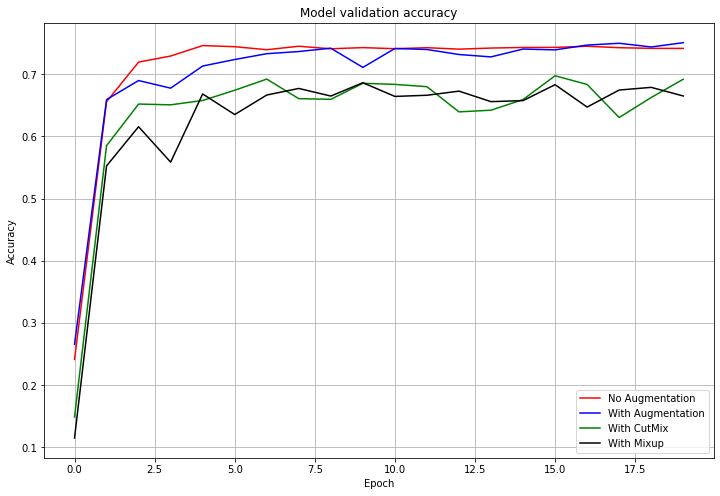

In [27]:
plt.figure(figsize=(12, 8))
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'With Mixup'], loc='lower right')
plt.grid(True)
plt.show()

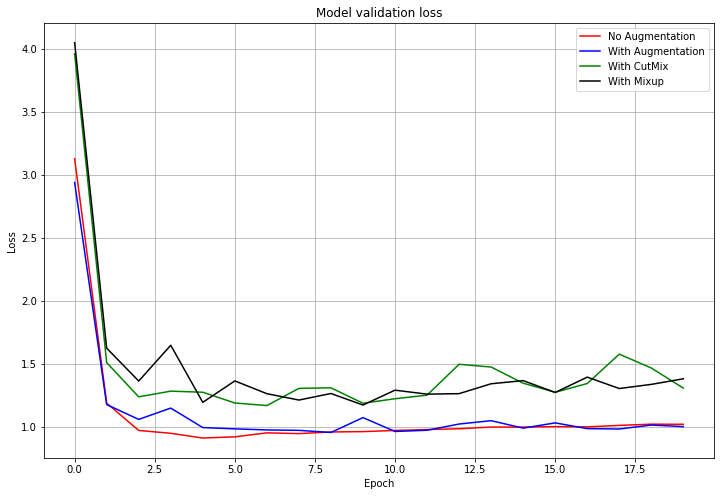

In [28]:
plt.figure(figsize=(12, 8))
plt.plot(history_resnet50_no_aug.history['val_loss'], 'r')
plt.plot(history_resnet50_aug.history['val_loss'], 'b')
plt.plot(history_resnet50_cutmix.history['val_loss'], 'g')
plt.plot(history_resnet50_mixup.history['val_loss'], 'k')
plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'With Mixup'], loc='upper right')
plt.grid(True)
plt.show()

## 6. Augmentation에 의한 모델 성능 비교

총 20epoch 학습 중 마지막 3 epoch에서 나온 정확도를 비교해보자.

In [31]:
import pandas as pd

acc_data = {'No Augmentation': history_resnet50_no_aug.history['val_accuracy'], 
            'With Augmentation': history_resnet50_aug.history['val_accuracy'], 
            'With CutMix': history_resnet50_cutmix.history['val_accuracy'], 
            'With Mixup': history_resnet50_mixup.history['val_accuracy']}
acc_df = pd.DataFrame(acc_data)
acc_df[-3:]

,No Augmentation,With Augmentation,With CutMix,With Mixup
17,0.742770,0.749883,0.630480,0.674673
18,0.741721,0.743937,0.662663,0.678988
19,0.741605,0.750816,0.692048,0.665112


상대적으로 No Augmentation 보다 기본 Augmentation 을 진행했을 때 정확도가 향상된 것을 알 수 있다.  

하지만 CutMix 와 Mixup Augmentation을 사용했을 경우에는 Augmentation 을 하지 않았을때보다 정확도가 감소한 것을 확인 할 수 있다.  

이것은 CutMix 와 Mixup 과정에서 개의 부분이 아니라 랜덤으로 바운딩박스의 위치를 뽑아서 모델이 학습하는 데에 악영향을 미친것으로 예상할 수 있다.